In [1]:
%load_ext autoreload

In [63]:
%autoreload

import matplotlib.pyplot as plt
import pandas as pd

from pyinla.model import *
from pyinla.utils import *

In [ ]:
# load dataset
ds = ro.r("data(Drivers); Drivers")[:192]

In [91]:
# you can mix R objects and python objects in the formula definition

params = dict(
    param_seasonal=[1, 0.1],
    season_length=12,
    intial_season=2,
)

formula = """
sqrt(y) ~ 1 + belt +
          f(trend, 
            model="rw2", 
            param=c(1.0, 0.0005),
            initial=-3) + 
          f(seasonal,
            model="seasonal", 
            season.length=season_length, 
            param=param_seasonal, 
            initial=2)
            """

In [92]:
result = inla(
    formula,
    data=pd_to_dict(ds) | params,  # as a dictionary.
    family="gaussian",
    control_inla=dict(h=0.01),
    control_predictor=dict(compute=True, link=1),
    control_compute=dict(config=True, return_marginals_predictor=True),
).improve_hyperpar()

In [93]:
result

Time used:
     = 0.909,  = 0.937,  = 0.0747,  = 1.92 
Fixed effects:
              mean    sd 0.025quant 0.5quant 0.975quant   mode kld
(Intercept) 41.414 0.169     41.083   41.414     41.747 41.414   0
belt        -5.792 1.402     -8.550   -5.791     -3.045 -5.788   0

Random effects:
  Name	  Model
    trend RW2 model
   seasonal Seasonal model

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations 7329.099 8565.687    319.921 4488.505
Precision for trend                        5.170    1.607      2.719    4.935
Precision for seasonal                     0.918    0.143      0.653    0.914
                                        0.975quant    mode
Precision for the Gaussian observations   31103.66 794.543
Precision for trend                           8.99   4.497
Precision for seasonal                        1.21   0.913

Marginal log-Likelihood:  -429.46 
 is computed 
Posterior summaries for the 

In [94]:
fitted = result.get_marginal_type("fitted.values")
modes = np.stack(fitted.apply(lambda x: x.mode()))
stds = np.stack(fitted.apply(lambda x: x.quantile([0.025, 0.975])))

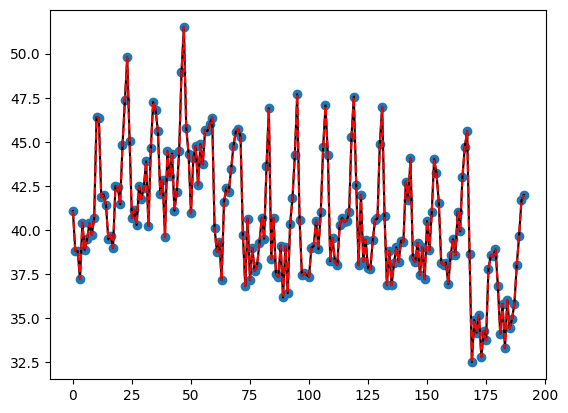

In [95]:
# posterior predictive check
xr = np.arange(len(ds))
plt.scatter(xr, np.sqrt(ds["y"].values))
plt.plot(xr, np.sqrt(ds["y"].values), c="k")
plt.plot(xr, modes, c="r", ls="--")
plt.fill_between(xr, stds[:, 0], stds[:, 1], alpha=0.2, color="r")

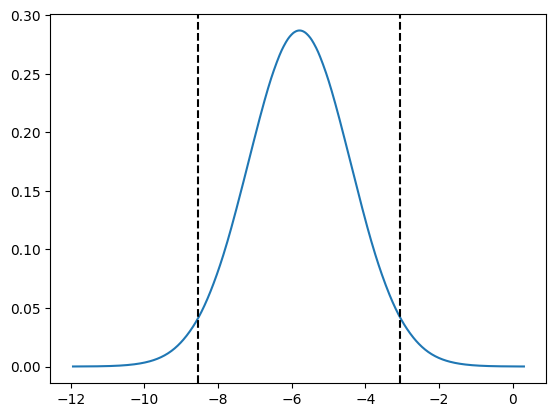

In [96]:
# check the marginal of belt. it is well below 0
belt = result.get_marginal_type("fixed").get_marginal("belt")
belt.spline().plot()
for i in belt.ci(0.95):
    plt.axvline(i, c="k", ls="--")